## Visualise image-specific class saliency with backpropagation

In [1]:
import matplotlib.pyplot as plt

import torch
import torchvision.models as models

from flashtorch.utils import (apply_transforms,
                              denormalize,
                              format_for_plotting,
                              load_image,
                              normalize,
                              visualize)

from flashtorch.utils import ImageNetIndex

from flashtorch.saliency import Backprop

### 2. Load a pre-trained Model

In [2]:
model = models.vgg16(pretrained=True)
list(model.features.named_children())

[('0', Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('1', ReLU(inplace)),
 ('2', Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('3', ReLU(inplace)),
 ('4',
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
 ('5', Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('6', ReLU(inplace)),
 ('7', Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('8', ReLU(inplace)),
 ('9',
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
 ('10', Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('11', ReLU(inplace)),
 ('12', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('13', ReLU(inplace)),
 ('14', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('15', ReLU(inplace)),
 ('16',
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
 ('17', Conv2d(256, 512, kernel_size=(3, 

In [22]:
import numpy as np

img_width = 224
img_height = 224

input_noise = np.uint8(np.random.uniform(150, 180, (3, 224, 224)))

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# for channel, _ in enumerate(input_noise):
#     input_noise[channel] = input_noise[channel] / 255
#     input_noise[channel] = input_noise[channel] - mean[channel]
#     input_noise[channel] = input_noise[channel] / std[channel]

print(input_noise.min(), input_noise.max())

150 179


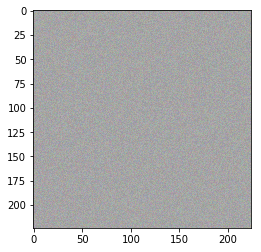

In [23]:
import matplotlib.pyplot as plt

plt.imshow(format_for_plotting(torch.from_numpy(input_noise)))

In [5]:
import pdb
import torch.nn as nn
import torch.optim as optim

class ActivationMaximization(nn.Module):
    def __init__(self, model, target=28):
        super().__init__()
        
        self.model = model
        self.target = target
        
        self.activation = None
        self.gradients = None
        
        self._register_hooks()
        self._register_conv_hook()

    def _register_conv_hook(self):
        def _record_gradients(module, grad_in, grad_out):
            if self.gradients.shape == grad_in[0].shape:
                self.gradients = grad_in[0]

        for _, module in self.model.named_modules():
            if isinstance(module, nn.modules.conv.Conv2d) and \
                    module.in_channels == 3:
                module.register_backward_hook(_record_gradients)
                break
    
    def _register_hooks(self):
        def _record_activation(module, input_, output):
            #  Visualise the 1st filter of the 5th conv layer
            self.activation = -torch.mean(output[:,0])
            
        self.model[self.target].register_forward_hook(_record_activation)
    
    def forward_backprop(self, x, num_iter=20):
        optimizer = optim.Adam([x], lr=0.1, weight_decay=1e-6)

        self.gradients = torch.zeros(input_.shape)
                                     
        for i in range(num_iter):
            optimizer.zero_grad()
            
            self.model(x)
            
            self.activation.backward()
            
            optimizer.step()
        
        return x

In [6]:
active_max = ActivationMaximization(model.features)

input_ = torch.from_numpy(input_noise).float()

input_.requires_grad = True

x = active_max.forward_backprop(input_)

TypeError: img should be PIL Image. Got <class 'torch.Tensor'>

In [ ]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
x = deprocess_image(x.detach().numpy().squeeze())

In [ ]:
plt.imshow(x)